In [1]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00


In [2]:
# Install necessary libraries
!pip install torch torchvision albumentations wandb
!pip install -q torchmetrics

# Import required libraries
import os
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torch import nn
import xml.etree.ElementTree as ET
import glob
from tqdm import tqdm


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
# Download the Pascal VOC 2012 dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

# Extract the dataset
!tar -xf VOCtrainval_11-May-2012.tar


--2024-08-09 10:16:37--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  32.2MB/s    in 49s     

2024-08-09 10:17:26 (39.0 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [4]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm

# Define paths for annotations and images
PATH_ANN = 'VOCdevkit/VOC2012/Annotations/'
PATH_IMG = 'VOCdevkit/VOC2012/JPEGImages/'

def xml_to_csv(path):
    xml_list = []
    for xml_file in tqdm(sorted(glob.glob(path + '*.xml'))):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        file_name = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        for member in root.findall('object'):
            xmin = int(float(member.find('bndbox').find('xmin').text))
            ymin = int(float(member.find('bndbox').find('ymin').text))
            xmax = int(float(member.find('bndbox').find('xmax').text))
            ymax = int(float(member.find('bndbox').find('ymax').text))

            value = (file_name,
                     member.find('name').text,
                     width,
                     height,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'class', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

annotations_df = xml_to_csv(PATH_ANN)
annotations_df.to_csv('pascal_voc_annotations.csv', index=False)


100%|██████████| 17125/17125 [00:01<00:00, 14030.82it/s]


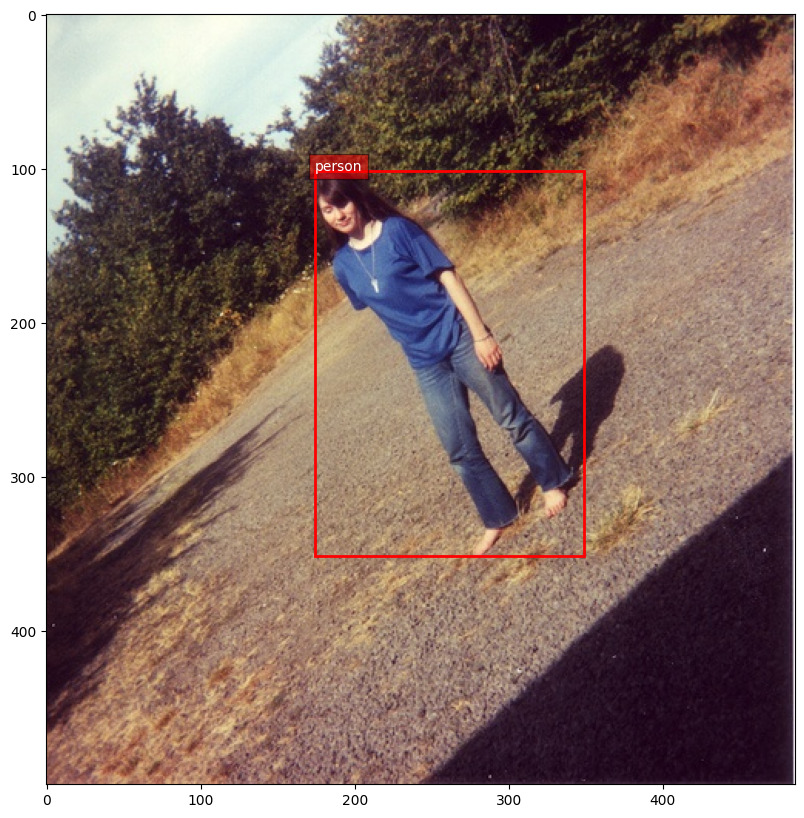

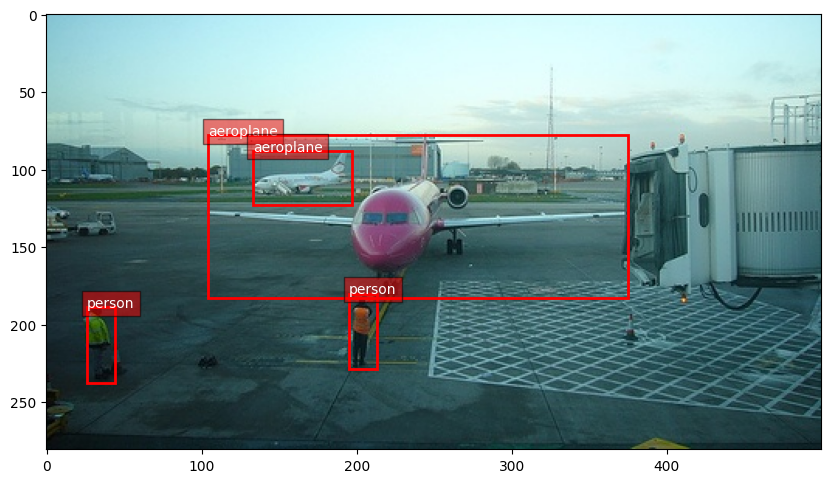

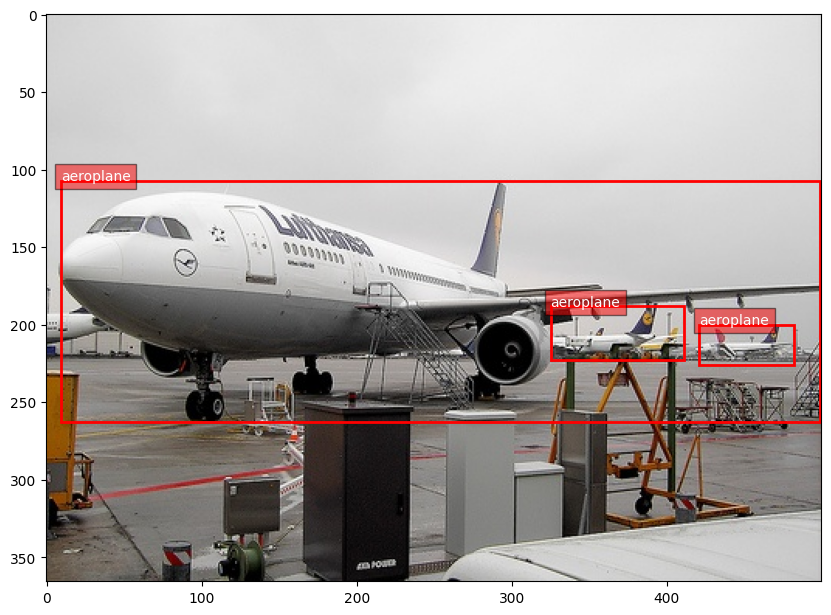

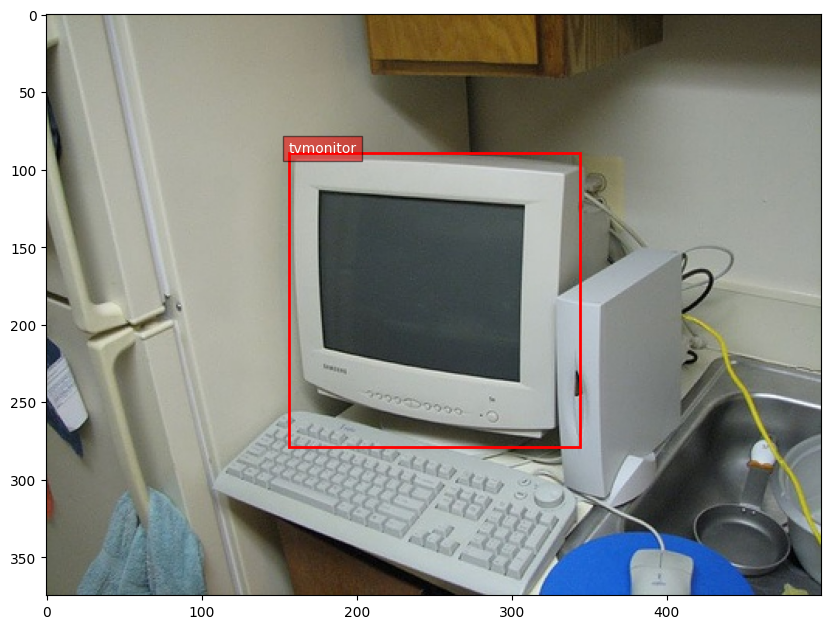

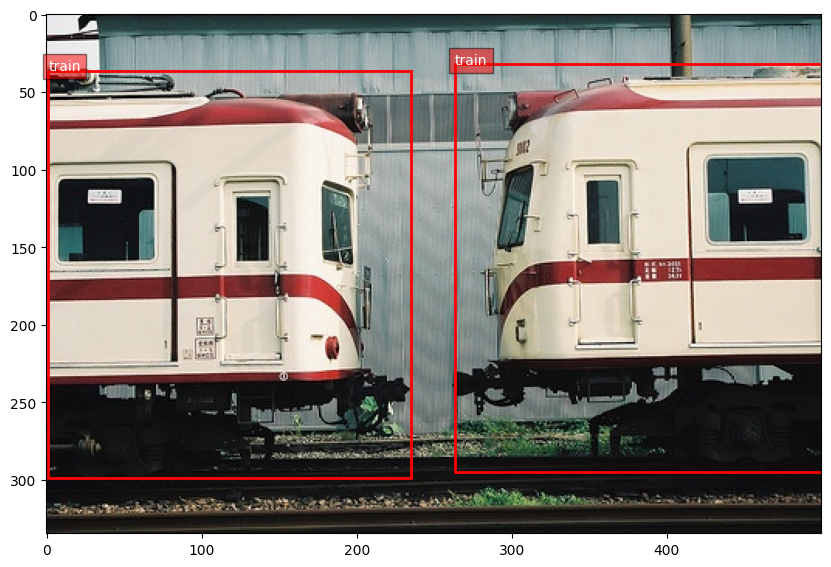

In [5]:
import cv2
import matplotlib.pyplot as plt

# Function to plot images with bounding boxes
def plot_image_with_boxes(img_path, boxes, labels):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                          linewidth=2, edgecolor='r', facecolor='none'))
        plt.text(xmin, ymin, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=10, color='white')
    plt.show()

# Plot some samples
sample_images = annotations_df['filename'].unique()[:5]
for img_file in sample_images:
    img_path = os.path.join(PATH_IMG, img_file)
    sample_boxes = annotations_df[annotations_df['filename'] == img_file][['xmin', 'ymin', 'xmax', 'ymax']].values
    sample_labels = annotations_df[annotations_df['filename'] == img_file]['class'].values
    plot_image_with_boxes(img_path, sample_boxes, sample_labels)


wandb: Currently logged in as: enxo7899 (em-city). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: enxo7899. Use `wandb login --relogin` to force relogin


Sample Batch Images Shape: torch.Size([2, 3, 400, 400])
Sample Batch Boxes: [tensor([[333.,   1., 500., 217.]]), tensor([[ 91., 148., 335., 465.]])]
Sample Batch Labels: [tensor(14), tensor(14)]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([21, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Batch [10/2007], Loss: 120.7740, RPN Cls Loss: 0.0566, RPN Reg Loss: 0.3558, ROI Cls Loss: 106.0938, ROI Reg Loss: 376.5898
Batch [20/2007], Loss: 97.1509, RPN Cls Loss: 0.0544, RPN Reg Loss: 0.3600, ROI Cls Loss: 113.0938, ROI Reg Loss: 275.0953
Batch [30/2007], Loss: 135.9923, RPN Cls Loss: 0.1337, RPN Reg Loss: 0.4092, ROI Cls Loss: 5.5566, ROI Reg Loss: 537.8696
Batch [40/2007], Loss: 70.9921, RPN Cls Loss: 0.0412, RPN Reg Loss: 0.2541, ROI Cls Loss: 8.1055, ROI Reg Loss: 275.5677
Batch [50/2007], Loss: 117.9935, RPN Cls Loss: 0.0920, RPN Reg Loss: 0.3006, ROI Cls Loss: 15.8320, ROI Reg Loss: 455.7492
Batch [60/2007], Loss: 107.7585, RPN Cls Loss: 0.0063, RPN Reg Loss: 0.2773, ROI Cls Loss: 12.4062, ROI Reg Loss: 418.3441
Batch [70/2007], Loss: 96.7794, RPN Cls Loss: 0.0041, RPN Reg Loss: 0.2646, ROI Cls Loss: 35.8193, ROI Reg Loss: 351.0298
Batch [80/2007], Loss: 103.9997, RPN Cls Loss: 0.0003, RPN Reg Loss: 0.2408, ROI Cls Loss: 65.0488, ROI Reg Loss: 350.7091
Batch [90/2007], Lo

<ipython-input-1-da0eadd1d8c9>:233: RuntimeWarning: overflow encountered in multiply
  box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])


Epoch [1/3], Total Loss: 270.2562
  RPN Classification Loss: 0.0050
  RPN Regression Loss: 0.0207
  ROI Classification Loss: 40.9387
  ROI Regression Loss: 229.2919
  Precision: 0.2023, Recall: 0.2183, F1 Score: 0.2466, FPS: 2.28
  IoU: 0.0908, mAP: 0.0117


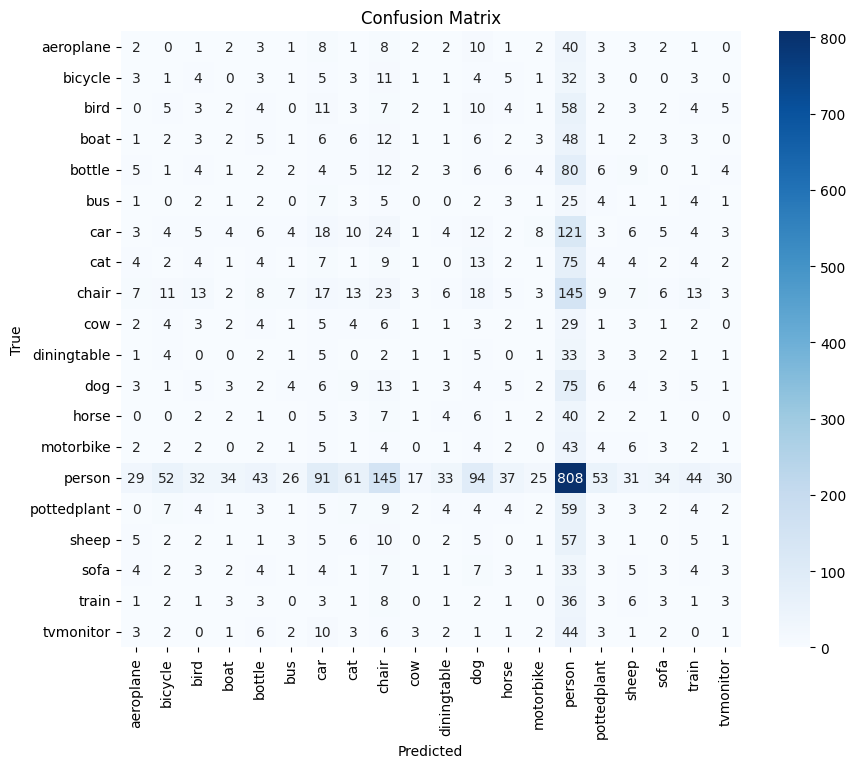

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:939: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([21, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Batch [10/2007], Loss: 50.2167, RPN Cls Loss: 0.0007, RPN Reg Loss: 0.0002, ROI Cls Loss: 10.8108, ROI Reg Loss: 190.0551
Batch [20/2007], Loss: 57.6115, RPN Cls Loss: 0.0002, RPN Reg Loss: 0.0002, ROI Cls Loss: 0.2277, ROI Reg Loss: 230.2180
Batch [30/2007], Loss: 67.5480, RPN Cls Loss: 0.0001, RPN Reg Loss: 0.0002, ROI Cls Loss: 12.0317, ROI Reg Loss: 258.1600
Batch [40/2007], Loss: 71.3722, RPN Cls Loss: 0.0002, RPN Reg Loss: 0.0002, ROI Cls Loss: 64.0625, ROI Reg Loss: 221.4258
Batch [50/2007], Loss: 48.0844, RPN Cls Loss: 0.0005, RPN Reg Loss: 0.0001, ROI Cls Loss: 58.0156, ROI Reg Loss: 134.3214
Batch [60/2007], Loss: 50.3568, RPN Cls Loss: 0.0002, RPN Reg Loss: 0.0005, ROI Cls Loss: 6.6855, ROI Reg Loss: 194.7411
Batch [70/2007], Loss: 82.8093, RPN Cls Loss: 0.0002, RPN Reg Loss: 0.0004, ROI Cls Loss: 10.2856, ROI Reg Loss: 320.9509
Batch [80/2007], Loss: 37.3043, RPN Cls Loss: 0.0015, RPN Reg Loss: 0.0002, ROI Cls Loss: 34.6055, ROI Reg Loss: 114.6101
Batch [90/2007], Loss: 54.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.ops as ops
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import wandb

# Initialize WandB
api_key = "9ce954fd827fd8d839648cb3708ff788ad51bafa"
wandb.login(key=api_key)
wandb.init(project="faster-rcnn-project-fromscratch", entity="enxo7899")

# Custom Dataset Class for Pascal VOC
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.annotations['class'] = self.label_encoder.fit_transform(self.annotations['class'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        boxes = self.annotations.iloc[idx, 4:].values.astype("float").reshape(-1, 4)
        labels = self.annotations.iloc[idx, 1].astype("int")

        sample = {"image": image, "boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor(labels, dtype=torch.int64)}

        if self.transform:
            sample["image"] = self.transform(sample["image"])

        return sample

# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((400, 400)),  # Resize images to a fixed size
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Custom collate function to handle batches with variable-length elements
def custom_collate(batch):
    images = [item['image'] for item in batch]
    boxes = [item['boxes'] for item in batch]
    labels = [item['labels'] for item in batch]
    return {'image': torch.stack(images), 'boxes': boxes, 'labels': labels}

# Initialize Dataset
dataset = PascalVOCDataset(root_dir="VOCdevkit/VOC2012/JPEGImages", annotations_file="pascal_voc_annotations.csv", transform=transform)

# Use a randomized subset for testing
subset_indices = random.sample(range(len(dataset)), len(dataset) // 10)  # Use 10% of the dataset randomly
subset = Subset(dataset, subset_indices)

# Initialize DataLoader with custom collate function
dataloader = DataLoader(subset, batch_size=2, shuffle=True, num_workers=2, pin_memory=True, collate_fn=custom_collate)

# Check a sample batch
sample_batch = next(iter(dataloader))
print("Sample Batch Images Shape:", sample_batch["image"].shape)
print("Sample Batch Boxes:", sample_batch["boxes"])
print("Sample Batch Labels:", sample_batch["labels"])

# Define a more complex ResNet-like backbone from scratch
class ComplexBackbone(nn.Module):
    def __init__(self):
        super(ComplexBackbone, self).__init__()
        self.layer1 = self._make_layer(3, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2)
        self.layer3 = self._make_layer(128, 256, 2)
        self.layer4 = self._make_layer(256, 512, 2)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True)]
        for _ in range(1, num_blocks):
            layers.extend([nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.ReLU(inplace=True)])
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Define the Region Proposal Network (RPN)
class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels, num_anchors=9):
        super(RegionProposalNetwork, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.cls_logits = nn.Conv2d(512, num_anchors * 2, kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.relu(self.conv(x))
        rpn_logits = self.cls_logits(x)
        rpn_bbox_pred = self.bbox_pred(x)
        return rpn_logits, rpn_bbox_pred

# Generate dummy proposals
def generate_dummy_proposals(feature_map_size, num_proposals=9):
    proposals = []
    for _ in range(num_proposals):
        x1 = torch.randint(0, feature_map_size // 2, (1,)).item()
        y1 = torch.randint(0, feature_map_size // 2, (1,)).item()
        x2 = x1 + torch.randint(16, 64, (1,)).item()  # Random width
        y2 = y1 + torch.randint(16, 64, (1,)).item()  # Random height
        proposals.append([x1, y1, x2, y2])
    return torch.tensor(proposals, dtype=torch.float32)

# Define RoI Pooling Layer
class RoIPooling(nn.Module):
    def __init__(self, output_size):
        super(RoIPooling, self).__init__()
        self.output_size = output_size

    def forward(self, features, proposals, image_shapes):
        return ops.roi_pool(features, proposals, self.output_size, spatial_scale=1.0)

# Define the Classification and Regression Heads
class ClassificationAndRegressionHeads(nn.Module):
    def __init__(self, in_features, num_classes):
        super(ClassificationAndRegressionHeads, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        cls_score = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)
        return cls_score, bbox_pred

# Assemble the complete Faster R-CNN model
class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn, roi_pooling, heads):
        super(FasterRCNN, self).__init__()
        self.backbone = backbone
        self.rpn = rpn
        self.roi_pooling = roi_pooling
        self.heads = heads

    def forward(self, images, proposals, image_shapes):
        # Extract features using the backbone
        features = self.backbone(images)
        # Generate proposals using the RPN
        rpn_logits, rpn_bbox_pred = self.rpn(features)
        # Perform RoI Pooling
        pooled_features = self.roi_pooling(features, proposals, image_shapes)
        # Classify and refine boxes
        cls_logits, bbox_pred = self.heads(pooled_features)
        return cls_logits, bbox_pred, rpn_logits, rpn_bbox_pred

# Define the loss functions
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model components with a complex backbone
backbone = ComplexBackbone()
rpn = RegionProposalNetwork(in_channels=512)  # Last feature map has 512 channels
roi_pooling = RoIPooling(output_size=(7, 7))
heads = ClassificationAndRegressionHeads(in_features=7*7*512, num_classes=21)

# Instantiate the complete model
model = FasterRCNN(backbone, rpn, roi_pooling, heads).to(device)

# Define optimizer with learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  # Reduce LR every 2 epochs

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Training parameters
num_epochs = 3  # Reduced for testing
log_interval = 10  # Log every 10 batches
gradient_accumulation_steps = 4  # Accumulate gradients over 4 batches

# Custom IoU calculation
def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) between two bounding boxes."""
    if len(box1) == 0 or len(box2) == 0:
        return np.array([0.0])

    # Ensure boxes are numpy arrays
    box1 = np.array(box1)
    box2 = np.array(box2)

    # Handle single box input
    if box1.ndim == 1:
        box1 = box1[np.newaxis, :]
    if box2.ndim == 1:
        box2 = box2[np.newaxis, :]

    # Determine the coordinates of the intersection rectangle
    inter_x1 = np.maximum(box1[:, 0], box2[:, 0])
    inter_y1 = np.maximum(box1[:, 1], box2[:, 1])
    inter_x2 = np.minimum(box1[:, 2], box2[:, 2])
    inter_y2 = np.minimum(box1[:, 3], box2[:, 3])

    # Compute the area of intersection rectangle
    inter_area = np.maximum(inter_x2 - inter_x1, 0) * np.maximum(inter_y2 - inter_y1, 0)

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    # Compute the area of union
    union_area = box1_area + box2_area - inter_area

    # Compute the IoU
    iou = inter_area / np.maximum(union_area, 1e-8)

    return iou

# Function to calculate mean Average Precision (mAP)
def calculate_map(true_boxes, pred_boxes, iou_threshold=0.5):
    """Calculates the mean Average Precision (mAP) over a dataset."""
    all_precisions = []

    for tb, pb in zip(true_boxes, pred_boxes):
        if len(pb) == 0:
            all_precisions.append(0)
            continue

        ious = calculate_iou(tb, pb)
        sorted_indices = np.argsort(-ious)
        ious = ious[sorted_indices]

        tp = ious >= iou_threshold
        fp = ious < iou_threshold

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)

        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
        recall = tp_cumsum / (len(tb) + 1e-8)

        precision = np.concatenate(([1.0], precision, [0.0]))
        recall = np.concatenate(([0.0], recall, [1.0]))

        for i in range(len(precision) - 1, 0, -1):
            precision[i - 1] = np.maximum(precision[i - 1], precision[i])

        indices = np.where(recall[1:] != recall[:-1])[0]
        ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
        all_precisions.append(ap)

    return np.mean(all_precisions) if all_precisions else 0.0

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    rpn_cls_loss_epoch = 0.0
    rpn_reg_loss_epoch = 0.0
    roi_cls_loss_epoch = 0.0
    roi_reg_loss_epoch = 0.0

    start_time = time.time()

    all_true_labels = []
    all_pred_labels = []
    all_true_boxes = []
    all_pred_boxes = []

    for batch_idx, batch in enumerate(dataloader):
        images = batch['image'].to(device, non_blocking=True)
        targets = [{'boxes': boxes.to(device, non_blocking=True), 'labels': labels.to(device, non_blocking=True)} for boxes, labels in zip(batch['boxes'], batch['labels'])]

        # Image shapes should match the original shapes before resizing
        image_shapes = [(img.size(1), img.size(2)) for img in images]  # (height, width) format

        # Generate proposals for each image in the batch
        proposals = [generate_dummy_proposals(image_shapes[i][0]).to(device) for i in range(len(images))]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            cls_logits, bbox_pred, rpn_logits, rpn_bbox_pred = model(images, proposals, image_shapes)

            # Calculate losses for each image
            rpn_cls_loss = 0
            rpn_reg_loss = 0
            roi_cls_loss = 0
            roi_reg_loss = 0

            for i in range(len(images)):
                # Calculate RPN classification loss
                rpn_logits_flat = rpn_logits[i].permute(1, 2, 0).reshape(-1, 2)
                rpn_targets = torch.zeros(rpn_logits_flat.shape[0], dtype=torch.long, device=device)  # Dummy target

                rpn_cls_loss += classification_loss_fn(rpn_logits_flat, rpn_targets)

                # Calculate RPN regression loss (using dummy targets here)
                rpn_bbox_pred_flat = rpn_bbox_pred[i].permute(1, 2, 0).reshape(-1, 4)
                rpn_reg_loss += bbox_loss_fn(rpn_bbox_pred_flat, torch.zeros_like(rpn_bbox_pred_flat, device=device))

                # Calculate ROI losses
                roi_cls_loss += classification_loss_fn(cls_logits[i].view(-1, 21), targets[i]['labels'].view(-1))
                roi_reg_loss += bbox_loss_fn(bbox_pred[i].view(-1, 4), targets[i]['boxes'].view(-1, 4))

                # Collect predictions for metrics
                all_true_labels.append(targets[i]['labels'].item())
                all_pred_labels.append(torch.argmax(cls_logits[i]).item())

                # Collect true and predicted boxes for IoU and mAP calculation
                all_true_boxes.append(targets[i]['boxes'].cpu().numpy())
                all_pred_boxes.append(bbox_pred[i].detach().cpu().numpy())

            # Total loss
            loss = (rpn_cls_loss + rpn_reg_loss + roi_cls_loss + roi_reg_loss) / gradient_accumulation_steps

        # Backward pass and optimize
        scaler.scale(loss).backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Accumulate losses
        epoch_loss += loss.item() * gradient_accumulation_steps
        rpn_cls_loss_epoch += rpn_cls_loss.item()
        rpn_reg_loss_epoch += rpn_reg_loss.item()
        roi_cls_loss_epoch += roi_cls_loss.item()
        roi_reg_loss_epoch += roi_reg_loss.item()

        # Log batch info
        if (batch_idx + 1) % log_interval == 0:
            print(f"Batch [{batch_idx + 1}/{len(dataloader)}], "
                  f"Loss: {loss.item():.4f}, "
                  f"RPN Cls Loss: {rpn_cls_loss.item():.4f}, "
                  f"RPN Reg Loss: {rpn_reg_loss.item():.4f}, "
                  f"ROI Cls Loss: {roi_cls_loss.item():.4f}, "
                  f"ROI Reg Loss: {roi_reg_loss.item():.4f}")

    # Calculate metrics
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
    f1 = f1_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
    cm = confusion_matrix(all_true_labels, all_pred_labels)
    iou = np.mean([np.max(calculate_iou(tb, pb)) for tb, pb in zip(all_true_boxes, all_pred_boxes) if len(tb) > 0 and len(pb) > 0])
    map_score = calculate_map(all_true_boxes, all_pred_boxes)

    fps = len(dataloader.dataset) / (time.time() - start_time)  # Frames Per Second

    # Print epoch loss and metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss/len(dataloader):.4f}")
    print(f"  RPN Classification Loss: {rpn_cls_loss_epoch/len(dataloader):.4f}")
    print(f"  RPN Regression Loss: {rpn_reg_loss_epoch/len(dataloader):.4f}")
    print(f"  ROI Classification Loss: {roi_cls_loss_epoch/len(dataloader):.4f}")
    print(f"  ROI Regression Loss: {roi_reg_loss_epoch/len(dataloader):.4f}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, FPS: {fps:.2f}")
    print(f"  IoU: {iou:.4f}, mAP: {map_score:.4f}")

    # Log metrics to WandB
    wandb.log({
        "Epoch": epoch + 1,
        "Total Loss": epoch_loss / len(dataloader),
        "RPN Classification Loss": rpn_cls_loss_epoch / len(dataloader),
        "RPN Regression Loss": rpn_reg_loss_epoch / len(dataloader),
        "ROI Classification Loss": roi_cls_loss_epoch / len(dataloader),
        "ROI Regression Loss": roi_reg_loss_epoch / len(dataloader),
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "IoU": iou,
        "mAP": map_score,
        "FPS": fps
    })

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.label_encoder.classes_, yticklabels=dataset.label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Update learning rate
    scheduler.step()

    # Save model checkpoint
    torch.save(model.state_dict(), f'faster_rcnn_epoch_{epoch+1}.pth')

print("Training complete.")

# Finish the WandB run
wandb.finish()


Inference


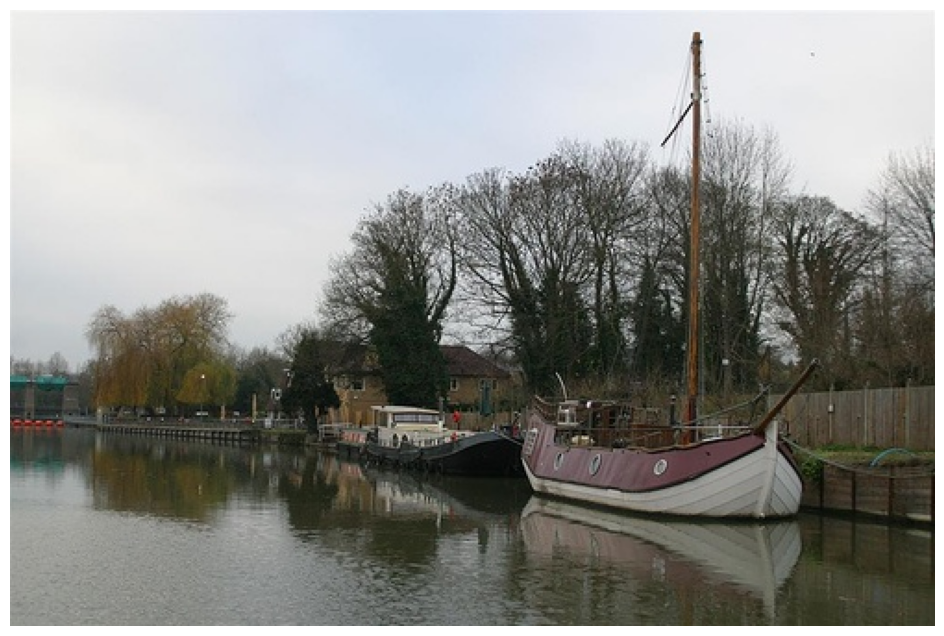

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.ops as ops
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model = FasterRCNN(backbone, rpn, roi_pooling, heads).to(device)
model.load_state_dict(torch.load('path/name.pth'))
model.eval()  # Set the model to evaluation mode

# Define a transformation for the input image
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
])

# Define a function to perform inference on a single image
def perform_inference(image_path, model, device, threshold=0.5):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Generate dummy proposals for the image
    proposals = [generate_dummy_proposals(feature_map_size=50).to(device)]

    # Perform the forward pass
    with torch.no_grad():
        cls_logits, bbox_pred, _, _ = model(transformed_image, proposals, [(400, 400)])

    # Convert outputs to numpy arrays
    scores = torch.nn.functional.softmax(cls_logits, dim=-1).squeeze(0).cpu().numpy()
    bboxes = bbox_pred.view(-1, 4).cpu().numpy()

    # Ensure predictions are aligned
    if scores.shape[0] != bboxes.shape[0]:
        num_preds = min(scores.shape[0], bboxes.shape[0])
        scores = scores[:num_preds]
        bboxes = bboxes[:num_preds]

    # Filter predictions based on the threshold
    pred_labels = np.argmax(scores, axis=1)
    pred_scores = np.max(scores, axis=1)
    keep_indices = pred_scores > threshold
    pred_boxes = bboxes[keep_indices]
    pred_labels = pred_labels[keep_indices]
    pred_scores = pred_scores[keep_indices]

    # Visualize predictions
    visualize_predictions(image, pred_boxes, pred_labels, pred_scores)

# Define a function to visualize predictions
def visualize_predictions(image, boxes, labels, scores):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if len(box) == 4:  # Ensure box has 4 coordinates
            xmin, ymin, xmax, ymax = box
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
            ax.text(xmin, ymin - 2, f'{dataset.label_encoder.inverse_transform([label])[0]}: {score:.3f}',
                    bbox=dict(facecolor='blue', alpha=0.5), fontsize=10, color='white')

    plt.axis('off')
    plt.show()

# Perform inference on a given image
image_path = '/content/VOCdevkit/VOC2012/JPEGImages/2007_000061.jpg'  # Replace with your image path
perform_inference(image_path, model, device)
